# A general-Purpose Counting Filter

## Tool box

In [1]:
import array
import sys

class BitArray:
    def __init__(self,size):
        self._bits=8
        self._sizeInBits=size
        self._A=array.array("B",(0 for i in range(self._index(size)+1)))
    def _index(self,index):
        return index//self._bits
    def _mask(self,index):
        return 1<<(index%self._bits)        
    def __setitem__(self,indexInBits,value):
        if value == 0:
            self._A[self._index(indexInBits)]&=~self._mask(indexInBits)
        elif value == 1:
            self._A[self._index(indexInBits)]|=self._mask(indexInBits)
    def __getitem__(self,indexInBits):
        if  self._A[self._index(indexInBits)] & self._mask(indexInBits) != 0:
            return 1
        else:
            return 0
    def __repr__(self):
        return "".join(str(self[i]) for i in range(self._sizeInBits))
    def __sizeof__(self):
        return sys.getsizeof(self._A)
    
    def rank(self, up_to, starting=0):
        """ Return the number of 1 in the vector up to a position
        """
        rank = 0
        for i in range(starting, up_to+1):
            rank += self[i]
        return rank
    def select(self, number_of_one, starting=0):
        """ Return index of the i th one
        """
        index = starting-1
        actual_ones = 0
        # print("select:", number_of_one, "ac:", actual_ones, "index", index)
        while index < self._sizeInBits and actual_ones < number_of_one:
            index += 1
            actual_ones += self[index]
        # print("select:", number_of_one, "ac:", actual_ones, "index", index)
        return index
    
bits = BitArray(32)
bits[3] = 1
bits[1] = 1
bits[8] = 1
bits[9] = 1
bits[12] = 1
bits[30] = 1
bits[30] = 0

print(bits)
print(bits.rank(9))
print(bits.select(4))


01010000110010000000000000000000
4
9


## Bloom filter

In [2]:
class Bloom:
    def __init__(self,sizeInBits,hashCount):
        self._A=BitArray(sizeInBits)
        self._sizeInBits=sizeInBits
        self._hashCount=hashCount
    def add(self,item):
        out = [' ' for i in range(10)]
        for h in range(self._hashCount):
            self._A[hash((h,item))%self._sizeInBits]=1
            out[hash((h,item))%self._sizeInBits]='+'
        return "".join(out)
    def __contains__(self,item):
        return all(( self._A[hash((h,item)) % self._sizeInBits] for h in range(self._hashCount)))
    def __repr__(self):
        return repr(self._A)

In [3]:
import random

def randomStringOfChars(length):
    letters = "qwertyuiopasdfghjklzxcvbnnm"
    return "".join((random.choice(letters) for i in range(length)))

In [4]:
B = Bloom(8, 2)
print(B.add("Hello"))
print(B)
print(B.add("World"))
print(B)

   ++     
00011000
 ++       
01111000


# Quotient filter
The quotient filter **hashes** items to a p-bit fingerprint and uses
the **upper bits** of the fingerprint to **select a slot** in a table, where it
**stores the lower bits** of the fingerprint. It resolves collisions using a
variant of linear probing that maintains three metadata bits per slot.
During an insertion, elements are shifted around, similar to insertion
sort with gaps [6], so that elements are always **stored in order
of increasing hash value**.

In [5]:
class HashTable:
    def __init__(self,size):
        self._A=[ [] for i in range(size)]
        
    def _bucket(self,key):
        return self._A[hash(key)%len(self._A)]
    
    def __setitem__(self,key,value):
        bucket=self._bucket(key)
        for item in bucket:
            if item[0]==key:
                item[1]=value
                return
        bucket.append([key,value])
        
    def __getitem__(self,key):
        for k,v in self._bucket(key):
            if k==key:
                return v
        raise KeyError(key)
        
    def __contains__(self,key):
        for k,v in self._bucket(key):
            if k==key:
                return True
        return False
    
    def __delitem__(self,key):
        bucket=self._bucket(key)
        for i in range(len(bucket)):
            if bucket[i][0]==key:
                del bucket[i]
                return
        raise KeyError(str(key))
        
    def __str__(self):
        items=["{"]
        for bucket in self._A:
            for x in bucket:
                items.append(x)
        items.append('}')
        return "".join((str(x) for x in items))

    def __repr__(self):
        rep=""
        for i in range(len(self._A)):
            rep+=str(i)+": "+str(self._A[i])+"\n"
        return rep

HASH_SIZE = 8
HASH_MAX_VAL = 2 ** HASH_SIZE
SIZE = 2 ** (HASH_SIZE//2)


def get_high(value, bits_to_remove=HASH_SIZE//2):
    return value>>bits_to_remove
def get_low(value, bits_to_keep=HASH_SIZE//2):
    return value & (1<<bits_to_keep)-1
def hash_short(value):
    return hash(value) % HASH_MAX_VAL
def split(item):
    h = hash_short(item)
    return get_high(h), get_low(h)
def to_bin_str(val, digit=HASH_SIZE//2):
    return ("{:0>"+str(digit)+"}").format(str(bin(val))[2:])



class Quotient:
    def __init__(self,size=SIZE):
        self.slot = [0 for i in range(size)]
        self.meta = [0b000 for i in range(size)]
        self.size = size
        
    def add(self,item):
        key, value = split(h)
        self.slot[key] = value
        self.meta[key] |= 0b100
        
    def __contains__(self,item):
        key, value = split(h)
        if self.meta[key] == 0:
            return False
        # Look for the start of the cluster: Scan left
        # Until you find is_shifted = 0
        run_number = 0
        scanning_index = key
        while self.meta[scanning_index] & 0b001 != 0:
            if self.meta[scanning_index] & 0b100 == 1:
                run_number += 1
            scanning_index -= 1
        
        # Scan right. Keep the count of runs we must skip
        # - Each slot to the left of the canonical slot
        #   having is_occupied set indicates another run
        #   to be skipped -> increment running count (done)
        # - Each slot having is_continuation clear
        #   indicates the start of another run, thus the
        #   end of the previous run
        #   -> so we decrement the running count.
        running_count = 0
        while run_number != 0:
            if self.meta[scanning_index] & 0b010 == 0:
                run_number -= 1
            scanning_index += 1
        
        # When the running count reaches zero
        # we are scanning the quotient's run.
        
        while True:
            if self.slot[scanning_index] == value:
                return True
            scanning_index += 1
            if meta[scanning_index+1] & 0b010 != 0:
                break

        # We can compare the remainder in each slot
        # in the run with the reminder we are looking for.
        # If found, we report that the key is (probably)
        # in the filter otherwise we report that the key
        # is definitely not in the filter.
    
        return False
    
    def __str__(self):
        items=["{"]
        for bucket in self._A:
            for x in bucket:
                items.append(x)
        items.append('}')
        return "".join((str(x) for x in items))

    def __repr__(self):
        rep="{0:<{1}} |meta|{2:^{3}}|\n".format("Slot", HASH_SIZE//2, "Value", HASH_SIZE//2)
        for i in range(self.size):
            rep+=" {:>3} | {:>3}|{:>4} |\n".format(i, to_bin_str(self.meta[i],3), str(self.slot[i]))
        return rep

In [6]:
q = Quotient()
print(repr(q))
# q.add('Hello')
#print(split('Hello'))
#print('Hello' in q)
"""
q.add('World')
print(to_bin_str(hash_short('World'), 8))
q.add('I am')
print(to_bin_str(hash_short('I am'), 8))
q.add('a')
print(to_bin_str(hash_short('a'), 8))
q.add('wizzard')
print(to_bin_str(hash_short('wizzard'), 8))
print(repr(q))
"""


Slot |meta|Value|
   0 | 000|   0 |
   1 | 000|   0 |
   2 | 000|   0 |
   3 | 000|   0 |
   4 | 000|   0 |
   5 | 000|   0 |
   6 | 000|   0 |
   7 | 000|   0 |
   8 | 000|   0 |
   9 | 000|   0 |
  10 | 000|   0 |
  11 | 000|   0 |
  12 | 000|   0 |
  13 | 000|   0 |
  14 | 000|   0 |
  15 | 000|   0 |



"\nq.add('World')\nprint(to_bin_str(hash_short('World'), 8))\nq.add('I am')\nprint(to_bin_str(hash_short('I am'), 8))\nq.add('a')\nprint(to_bin_str(hash_short('a'), 8))\nq.add('wizzard')\nprint(to_bin_str(hash_short('wizzard'), 8))\nprint(repr(q))\n"

# Rank and Select Quotient Filter

Improve the Quotient filter in 3 ways:
- 2.125 bits of metadata per slot
- High load of 95%
- Metadata operations can be performed using bit vector operations

## Rank and Select

In [7]:
class RankSelectQuotienFilter:
    def __init__(self, quotient_size, reminder_size):
        self.hash_size = quotient_size + reminder_size
        self.q_size = quotient_size
        self.r_size = reminder_size
        self.table_length = 2**self.q_size
        if self.r_size <= 8:
            self.reminders = array.array("B",(0 for i in range(self.table_length)))
        else:
            self.reminders = array.array("i",(0 for i in range(self.table_length)))
        self.occupied = BitArray(self.table_length)
        self.run_ends = BitArray(self.table_length)
        
        
    def RSHash(self, val):
        return hash(val) % (1<<self.hash_size)
    
    def get_quotient(self, val):
        return get_high(val, bits_to_remove=self.r_size)
    
    def get_reminder(self, val):
        return get_low(val, bits_to_keep=self.r_size)
    
    def find_end_of_run(self, q):
        rank = self.occupied.rank(q)
        return self.run_ends.select(rank)
        
    
    def insert(self, elem):
        h = self.RSHash(elem)
        q, r = self.get_quotient(h), self.get_reminder(h)
        # print(q, r)
        # Find end of run for quotient q
        select = self.find_end_of_run(q)
        # If slot not in use
        if q > select:
            self.reminders[q] = r
            self.run_ends[q] = 1
        # If slot in use
        else:
            select += 1
            n = self.first_unused_slot(select)
            if n >= self.table_length:
                return  # /!\ Create false NEGATIVES
            while n > select:
                self.left_shift_metadata_case(n)
                n -= 1
            self.reminders[select] = r
            if self.occupied[q] == 1:
                self.run_ends[select - 1] = 0
            self.run_ends[select] = 1
        self.occupied[q] = 1
    
    def left_shift_metadata_case(self, n):
        self.reminders[n] = self.reminders[n-1]
        self.run_ends[n] = self.run_ends[n-1]
    
    def first_unused_slot(self, x):
        select = self.find_end_of_run(x)
        while x <= select:
            x = select + 1
            select = self.find_end_of_run(x)
        return x
    
    def __contains__(self, value):
        h = self.RSHash(value)
        q, r = self.get_quotient(h), self.get_reminder(h)
        # If not occupied -> False
        if self.occupied[q] == 0:
            return False
        # Else
        select = self.find_end_of_run(q)
        #Run back all the run
        while True:
            if self.reminders[select] == r:
                return True
            select -= 1
            if select < q or self.run_ends[select] == 1:
                break;
        return False
    
    def __repr__(self):
        line_1 = " occupied  " + " | ".join("{}".format(self.occupied[i]) for i in range(self.occupied._sizeInBits))
        line_2 = "  run end  " + " | ".join("{}".format(self.run_ends[i]) for i in range(self.run_ends._sizeInBits))
        line_3 = "reminders " + "|".join("{:^3}".format(reminder) for reminder in self.reminders)
        return line_1 + "\n" + line_2 + "\n" +  line_3 + "\n"


In [10]:
RSQF = RankSelectQuotienFilter(4,4)
data = []
for i in range(10):
    elem = random.randint(10, 100)
    RSQF.insert(elem)
    data.append(elem)
print("Inserted:", data)
print(RSQF)


Inserted: [100, 15, 50, 63, 77, 11, 48, 16, 18, 68]
 occupied  1 | 1 | 0 | 1 | 1 | 0 | 1 | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 0
  run end  0 | 1 | 0 | 1 | 0 | 0 | 1 | 0 | 1 | 1 | 0 | 0 | 0 | 0 | 0 | 0
reminders 15 |11 | 0 | 2 | 2 |15 | 0 |13 | 4 | 4 | 0 | 0 | 0 | 0 | 0 | 0 



In [11]:
trials = 100000
FP = 0
for i in range(trials):
    FP += random.randint(101, 1000) in RSQF
print((FP/trials) * 100)

3.444


TODO :
- Resize
- Merge
- Delete

**Advantage:**
- Only 2 bits of meta data per block

**Drawbacks:**
- RANK and SELECT are at worst O(n)
- Not cache friendly

## RSQF With Offset

To compute the position of a run, we add an offset array

In [12]:
class RSQF_Offset(RankSelectQuotienFilter):
    def __init__(self, r, q):
        RankSelectQuotienFilter.__init__(self, r, q)
        self.offset_freq = 1
        self.num_offset = (self.table_length-1)//self.offset_freq+1
        self.offsets = array.array("B",(0 for i in range(self.num_offset)))
    
    def offset(self, i):  #Never used...
        return max(0, self.find_end_of_run(i) - i)
    
    def left_shift_metadata_case(self, n):
        RankSelectQuotienFilter.left_shift_metadata_case(self, n)
        if n%self.offset_freq == 0:
            self.offsets[n//self.offset_freq] += 1
    
    def estimate_offset(self, j):
        if j % self.offset_freq == 0:
            print("off", self.offsets[j//self.offset_freq])
            return self.offsets[j//self.offset_freq]-1
        else:
            previous_offset = j//self.offset_freq
            d = self.occupied.rank(j, starting=previous_offset*self.offset_freq)
            t = self.run_ends.select(d, starting = previous_offset*self.offset_freq + self.offsets[previous_offset] + 1)
            #print("d, t =",d, t)
            #off = max(0, previous_offset*self.offset_freq + t - j)
            off = t - j
            #print("offset = ", off)
            return off
    
    def find_end_of_run(self, q):
        # print("Good position for ", q,":", super().find_end_of_run(q))
        # print("       offset for ", q,":", self.estimate_offset(q))
        # TODO: Compute it here.
        """
        print("Find_end_of_run for q =", q)
        previous_offset_val = self.offsets[(q//self.offset_freq)]
        previous_offset_pos = (q//self.offset_freq)*self.offset_freq
        print("Prev offset", previous_offset_pos,"of value", previous_offset_val)
        d = self.occupied.rank(q, previous_offset_pos)
        t = self.run_ends.select(d, q + previous_offset_val+1)
        print("Number of 1 from", q, ":", d, "end run:", t)
        end_run = previous_offset_val + t
        print("Computed end_run:", end_run)
        print(self)
        return end_run
        """
        return self.offsets[q] + q -1
    
    def __repr__(self):
        line_0 = "   offset  " + (" | " + "    "*(self.offset_freq-1)).join("{}".format(self.offsets[i]) for i in range(self.num_offset))
        return line_0 + "\n" + RankSelectQuotienFilter.__repr__(self)
        

RSQF_O = RSQF_Offset(4,4)
RSQF_Classic = RankSelectQuotienFilter(4,4)
for i in range(10):
    print("inserting", i)
    elem = random.randint(10, 100)
    RSQF_Classic.insert(elem)
    RSQF_O.insert(elem)
    # print(RSQF_Classic)
    # print(RSQF_O)
    # print()
print("Offset")
print(RSQF_O)
print("\nClassic")
print(RSQF_Classic)

inserting 0
inserting 1
inserting 2
inserting 3
inserting 4
inserting 5
inserting 6
inserting 7
inserting 8
inserting 9
Offset
   offset  0 | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 0
 occupied  1 | 1 | 1 | 1 | 1 | 1 | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 0
  run end  1 | 1 | 1 | 1 | 1 | 1 | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 0
reminders 15 | 2 | 2 | 0 |13 |11 | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 0 


Classic
 occupied  1 | 1 | 1 | 1 | 1 | 1 | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 0
  run end  0 | 1 | 1 | 1 | 0 | 0 | 1 | 0 | 1 | 1 | 0 | 0 | 0 | 0 | 0 | 0
reminders 12 |15 | 2 | 2 | 4 | 3 | 0 |14 |13 |11 | 0 | 0 | 0 | 0 | 0 | 0 



# Tests

## Error rate

The RSQF has a false positive rate of $2^{-r}$

Let's test that with a filter of reminder size $r = 8$ thus false positive rate of at most 0.4%

2 filters, of sizes $2^8 = 256$ and $2^{12} = 4096$

They says that it suports up to a load of 95%, let's fill them up to 90%


In [13]:
RSQF_256 = RankSelectQuotienFilter(8, 8)
RSQF_4096 = RankSelectQuotienFilter(12, 8)

for i in range(int(256*0.90)):
    RSQF_256.insert(random.randint(0, 10000000))
    
for i in range(int(4096*0.90)):
    RSQF_4096.insert(random.randint(0, 10000000))
    

In [14]:
def false_positive_rate(RS_filter, trials=100000):
    false_positive = 0
    for i in range(trials):
        data = random.randint(2000000,3000000)
        if data in RS_filter:
            false_positive += 1
    return false_positive/i

In [26]:
false_positive_256 = 0
false_positive_4096 = 0
# print(RSQF_256)
# print(RSQF_4096)
trials = 20000
plot_FP_256 = []
plot_FP_4096 = []
for i in range(trials):
    data = random.randint(2000000,3000000)
    if data in RSQF_256:
        false_positive_256 += 1
        plot_FP_256.append((i, 100*false_positive_256/i))
    if data in RSQF_4096:
        false_positive_4096 += 1
        plot_FP_4096.append((i, 100*false_positive_4096/i))
    # print(i)
print(" FP 256 = " + str((false_positive_256/trials*100)) + "%")
print("FP 4096 = " + str((false_positive_4096/trials*100)) + "%")

 FP 256 = 0.32%
FP 4096 = 0.31%


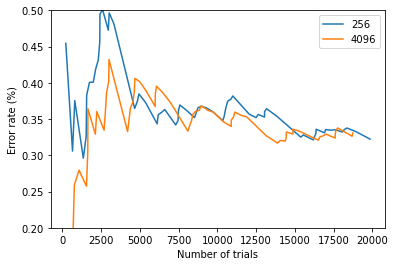

In [27]:
import matplotlib.pyplot as plt
import numpy as np


fig, ax = plt.subplots()
ax.set_ylabel('Error rate (%)')
ax.set_xlabel('Number of trials')
# ax1.set_title('a sine wave')
plt.ylim(0.2,0.5)
plt.plot(*zip(*plot_FP_256), label='256')
plt.plot(*zip(*plot_FP_4096), label='4096')

ax.legend()
plt.show()

We see that for both filters, it converges below 0.4% as expected

Now let's how the the filter of size 256 fasle positive rate looks for differtents fillings

In [28]:
RSQF_2 = RankSelectQuotienFilter(8,8)
plot = []
filling_step = int(256*(0.10))
print(filling_step)
for step in range(10):
    print(step, "/ 9")
    false_positive = false_positive_rate(RSQF_2, trials=100000)*100
    plot.append((step*10, false_positive))
    for i in range(filling_step):
        RSQF_2.insert(random.randint(0, 10000000))
false_positive = false_positive_rate(RSQF_2, trials=100000)*100
plot.append(((step+1)*10, false_positive))


25
0 / 9
1 / 9
2 / 9
3 / 9
4 / 9
5 / 9
6 / 9
7 / 9
8 / 9
9 / 9


[(0, 0.0), (10, 0.04200042000420004), (20, 0.08500085000850008), (30, 0.1040010400104001), (40, 0.16900169001690019), (50, 0.16400164001640016), (60, 0.2120021200212002), (70, 0.26200262002620023), (80, 0.28200282002820026), (90, 0.35000350003500036), (100, 0.39400394003940037)]


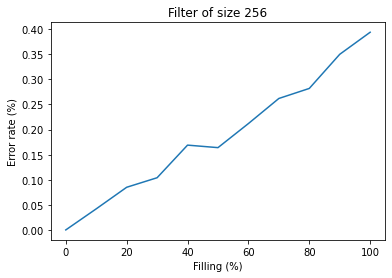

In [29]:
print(plot)
fig, ax = plt.subplots()

ax.plot(*zip(*plot))
ax.set_title('Filter of size 256')
ax.set_ylabel('Error rate (%)')
ax.set_xlabel('Filling (%)')

plt.show()

#### Error rate:  varing the reminder size

Let's take filters of size 256 but varying reminder size

We fill them up to 80%

In [30]:
RSQF_r4 = RankSelectQuotienFilter(8,4)
RSQF_r8 = RankSelectQuotienFilter(8,8)
RSQF_r12 = RankSelectQuotienFilter(8,12)
RSQF_r16 = RankSelectQuotienFilter(8,16)
filter_list = [RSQF_r4, RSQF_r8, RSQF_r12, RSQF_r16]
false_positive_rates = []
for f in filter_list:
    for i in range(int(256*0.80)):
        f.insert(random.randint(0, 10000000))
    false_positive_rates.append(false_positive_rate(f, 500000)*100)


[4.831209662419325, 0.31000062000124, 0.0186000372000744, 0.0024000048000096]


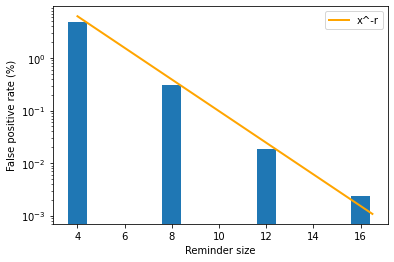

In [31]:
fig, ax = plt.subplots()
names = [4, 8, 12, 16]


ax.bar(names, false_positive_rates)
print(false_positive_rates)
def f(x):
    return 2**(-x)*100
t1 = np.arange(4, 17, 0.5)
ax.plot(t1, f(t1), label="x^-r", color='orange', lw=2)

ax.set_yscale('log')
ax.set_xlabel('Reminder size')
ax.set_ylabel('False positive rate (%)')

plt.legend()
plt.show()

## Query time

Let's now evaluate the querry time

#### Quotient sizes

In [32]:
RSQF_time_16 = RankSelectQuotienFilter(4, 8)
RSQF_time_256 = RankSelectQuotienFilter(8, 8)
RSQF_time_4096 = RankSelectQuotienFilter(12, 8)
RSQF_time_16384 = RankSelectQuotienFilter(14, 8)


for i in range(int(16*0.60)):
    RSQF_time_16.insert(random.randint(0, 10000000))
for i in range(int(256*0.60)):
    RSQF_time_256.insert(random.randint(0, 10000000))
for i in range(int(4096*0.60)):
    RSQF_time_4096.insert(random.randint(0, 10000000))
print("over")
for i in range(int(16384*0.60)):
    RSQF_time_16384.insert(random.randint(0, 10000000))
    if i%1000 == 0:
        print(i)

over
0
1000
2000
3000
4000
5000
6000
7000
8000
9000


In [33]:
import time

filters = [RSQF_time_16, RSQF_time_256, RSQF_time_4096, RSQF_time_16384]
times = []

trials = 1000
for f in filters:
    start = time.time()
    for i in range(trials):
        random.randint(0, 1000000) in f
    end = time.time()
    times.append(end-start)
    

[0.008904457092285156, 0.0740513801574707, 1.0721454620361328, 1.2285590171813965]


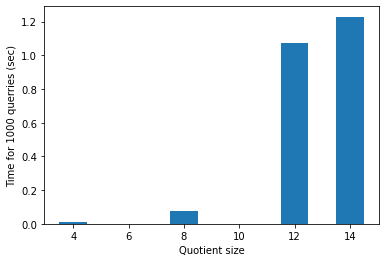

In [34]:
import math

fig, ax = plt.subplots()
# names = [2**4, 2**8, 2**12, 2**14]
names = [4, 8, 12, 14]

ax.bar(names, times, width = 1)

ax.set_xlabel('Quotient size')
ax.set_ylabel('Time for 1000 querries (sec)')
print(times)
plt.show()

#### Load factor

In [35]:
RSQF_load = RankSelectQuotienFilter(8,8)
plot = []
filling_step = int(2**8*(0.10))
trials = 10000
steps = 20
for step in range(10):
    start = time.time()
    for i in range(trials):
        random.randint(0, 1000000) in RSQF_load
    end = time.time()
    plot.append((step*10, end-start))
    for i in range(filling_step):
        RSQF_load.insert(random.randint(0, 10000000))

start = time.time()
for i in range(trials):
    random.randint(0, 1000000) in RSQF_load
end = time.time()
plot.append(((step+1)*10, end-start))

[0.008904457092285156, 0.0740513801574707, 1.0721454620361328, 1.2285590171813965]


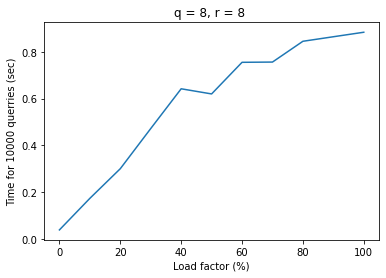

In [36]:
fig, ax = plt.subplots()

ax.plot(*zip(*plot))

ax.set_title('q = 8, r = 8 ')
ax.set_xlabel('Load factor (%)')
ax.set_ylabel('Time for 10000 querries (sec)')
print(times)
plt.show()